# FINAL PROJECT: DỰ BÁO TẢI ĐIỆN VN


### SESSION 6 - BIG DATA ANALYTICS COURSE

#### Group No Pain No Gain


1. [I. Business understanding](#1)
1. [II. Data mining](#2)
1. [III. Data processing](#3)
1. [IV. Data exploration](#4)
1. [V. Feature engineering](#5)
1. [VI. Predictive modeling](#6)
1. [VII. Data visualation](#7)

<a id="1"></a>
<h1 style = "color:Maroon" >I. Business understanding </h1>
<p>

<p>
Mục này là xác định bài toán cần giải quyết từ đó đưa ra phương pháp tính toán và thu thập data. <br/>
Dự báo TỔNG SẢN LƯỢNG ĐIỆN của ngày tiếp theo (t+1) từ dữ liệu tiêu thụ điện đã cung cấp <br/>
Kết quả là một số nên dùng dạng hồi quy để giải quyết bài toán <br/>
</p>

<a id="2"></a>
<h1 style = "color:Maroon ">II. Data mining </h1>
<p>
<p> Bức này mình sẽ thu thập data từ nhiều nguồn để giải quyết bài toán phía trên.
    <br/>
    Có 3 file data chứa thông tin cần được thu thập về:
    <li>HCM02-EProfile.csv : </li>
    <li>HCM02-ELog.csv : </li>
    <li>HCM02-EWeather.csv : </li>
</p>

In [1]:
%matplotlib inline

#imports
import plotly.express as px
import seaborn as sns
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F 
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, mean_squared_error, mean_absolute_error

<p style = "color: MidnightBlue ; font-weight: bold;">
 1. Load profit of customer data (HCM02-EProfile.csv)
</p>

In [2]:
#Load HCM02-EProfile.csv 
df_eprofit = pd.read_csv('Datasets/HCM02-EProfile.csv', index_col=0)
df_eprofit.head()

customer_id    registration_date city         sector
99    EX0031924  2018-11-27 00:00:00  HPG    Agriculture
20    EX0011899  2018-08-01 00:00:00  VPC       Domestic
55    EX0028218  2007-06-18 00:00:00  BDG       Domestic
102   EX0011584           01-06-2018  HNI       Industry
7     EX0069549           24-12-2018  VPC  Entertainment

<p style = "color: MidnightBlue ; font-weight: bold;">
 2. Load Meter index by customer data (HCM02-ELog.csv)
</p>

In [3]:
# Load HCM02-ELog.csv 
df_elog = pd.read_csv('Datasets/HCM02-ELog.csv', index_col=0)
df_elog.head()

customer_id     meter_id                   received_time   meter_idx  \
329060   EX0030895  MEXE6631620     April 01, 2020, 09:27:01 PM  27530.1600   
215307   EX0007732  MEXE9037803  December 02, 2019, 04:33:51 AM    696.4650   
513451   EX0083465  MEXE8173596   October 05, 2020, 04:13:01 AM  98926.4745   
77785    EX0011899  MEXE8290433       May 06, 2019, 06:07:45 AM   2117.8500   
428307   EX0003992  MEXE8205919      July 12, 2020, 08:16:25 PM   5073.6420   

       source  
329060  train  
215307  train  
513451   test  
77785   train  
428307  train

<p style = "color: MidnightBlue ; font-weight: bold;">
 3. Load the weather by time data (HCM02-EWeather.csv)
</p>

In [4]:
# Load HCM02-EWeather.csv 
df_eweather = pd.read_csv('Datasets/HCM02-EWeather.csv',  sep='\t', index_col=0)
df_eweather.head()

date city   temp dew_point humidity cloud_cover  \
32047   2019/10/31 07:00:00 AM  VPC  21.67     19.25     0.86        0.22   
5626    2019/08/23 10:00:00 AM  DNI  33.93     24.97      0.6        0.75   
13847   2019/03/02 11:00:00 PM  BDG  25.01     22.99     0.89        0.44   
75246   2019/02/09 06:00:00 AM  HPG  11.03     11.03      1.0        0.21   
101853  2020/11/08 09:00:00 PM  VPC  21.32      18.4      NAN        0.94   

                      trend                  summary wind_speed visibility  \
32047             clear-day                    Clear       1.41       7.89   
5626      partly-cloudy-day  Humid and Mostly Cloudy        1.0      10.01   
13847   partly-cloudy-night  Humid and Partly Cloudy        1.5       5.01   
75246                   fog                    Foggy        1.5       1.69   
101853               cloudy                 Overcast       1.69     16.093   

       pressure wind_bearing  
32047       NaN          NAN  
5626        NaN        320.0  
13847       NaN        120.0  
75246       NaN        221.0  
101853   1017.1        312.0

<a id="3"></a>
<h1 style = "color:Maroon ">III. Data processing </h1>

In this section, we need to fix inconsistencies with thin data and handle missing value

<p style = "color: MidnightBlue ; font-weight: bold;">
 1. Profit of customer data (HCM02-EProfile.csv)
</p>

In [5]:
# check information
df_eprofit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 99 to 49
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        173 non-null    object
 1   registration_date  173 non-null    object
 2   city               156 non-null    object
 3   sector             164 non-null    object
dtypes: object(4)
memory usage: 6.8+ KB


In [6]:
#check customer_id column in  df_eprofit table
df_eprofit.duplicated(subset=['customer_id']).sum()

14

In [7]:
# Displace all duplicates customer_id in df_eprofit
df_eprofit[df_eprofit.duplicated(subset=['customer_id'], keep = False)]

customer_id    registration_date city         sector
30    EX0050441  2020-03-18 00:00:00  NaN       Domestic
81    EX0071193           01-06-2020  KTM         Retail
0     EX0031466  2020-06-08 00:00:00   SG         Retail
107   EX0013504  2015-07-21 00:00:00  BDG   Construction
100   EX0031228  2020-09-24 00:00:00  HNI            NaN
46    EX0002468  2019-04-15 00:00:00  HNI       Industry
41    EX0023291  2019-10-31 00:00:00  HPG       Industry
91    EX0083660  2018-01-13 00:00:00  HNI          Hotel
50    EX0099453  2020-05-16 00:00:00   SG    Agriculture
59    EX0092085  2020-03-06 00:00:00  DNI       Domestic
163   EX0034195  2015-07-06 00:00:00  KTM  Entertainment
32    EX0031466  2016-02-16 00:00:00   SG         Retail
66    EX0059683           18-09-2015  HPG    Agriculture
42    EX0071193  2015-11-25 00:00:00  KTM         Retail
2     EX0088402  2020-01-13 00:00:00  VPC       Domestic
98    EX0092085  2015-10-30 00:00:00  DNI       Domestic
33    EX0023291  2020-09-22 00:00:00  HPG       Industry
6     EX0097202  2020-02-13 00:00:00   SG    Agriculture
125   EX0034195  2020-06-19 00:00:00  KTM  Entertainment
73    EX0088402  2020-07-21 00:00:00  VPC       Domestic
69    EX0097202  2019-02-12 00:00:00   SG    Agriculture
86    EX0050441  2018-10-26 00:00:00  KTM            NaN
87    EX0002468           23-04-2020  HNI       Industry
90    EX0083660  2020-07-25 00:00:00  HNI          Hotel
118   EX0031228  2019-01-10 00:00:00  HNI         Retail
96    EX0099453  2019-05-17 00:00:00   SG    Agriculture
153   EX0013504  2020-08-06 00:00:00  BDG   Construction
49    EX0059683  2020-06-27 00:00:00  HPG    Agriculture

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Quality issues
</h5>

<ol>
  <li style = "color: Navy ; bottom: 30px;">Data Types</li>
    Data Format for registration_date column in df_eprofit table ("HCM02-EProfile.csv") must be timestamp format instead of string format
    <br/> 
    Some records have DD/MM/YYYY format and others have YYYY/MM/DD
  <br/>  
  <li style = "color: Navy ; bottom: 30px;">Dupicate data</li>
    customer_id is primary keyword but it have duplicate data -> need to deduplicate, <b> logic is keep non null in city, sector col and last date of registration_date col </b>
  <br/>  
</ol>

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Solution
</h5>
<ol>    
<li style = "color: Navy ; bottom: 30px;">registration_date</li>
    -> change to datatime type
    
<br>
<li style = "color: Navy ; bottom: 30px;">customer_id</li>
    -> deduplate by groupby customer_id(sort registration_date ascending=False before groupby ), pick last registration_date and the first no null of city, sector
    
</ol>

In [8]:
# Change type of registration_date
df_eprofit['registration_date'] = pd.to_datetime(df_eprofit['registration_date'], infer_datetime_format=True);

# deduplicate customer_id
df_eprofit = df_eprofit.sort_values('registration_date', ascending=False).groupby('customer_id', as_index=False).agg({'registration_date':'max', 'city':'first','sector':'first'})

C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\607861107.py:2: UserWarning: Parsing '24-12-2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_eprofit['registration_date'] = pd.to_datetime(df_eprofit['registration_date'], infer_datetime_format=True);
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\607861107.py:2: UserWarning: Parsing '21-01-2005' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_eprofit['registration_date'] = pd.to_datetime(df_eprofit['registration_date'], infer_datetime_format=True);
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\607861107.py:2: UserWarning: Parsing '24-04-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_eprofit['registration_date'] = pd.to_datetime(df_eprofit['registration_date'], infer_datetime_format=True);
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\607861

In [9]:
# check result
df_eprofit.duplicated(subset=['customer_id']).sum()

0

In [10]:
# df_eprofit.to_csv('df_eprofit1.csv', index=False)

<p style = "color: MidnightBlue ; font-weight: bold;">
 2. Meter index by customer data (HCM02-ELog.csv)
</p>

In [11]:
# check information
df_elog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604134 entries, 329060 to 468578
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   customer_id    604134 non-null  object 
 1   meter_id       604134 non-null  object 
 2   received_time  604134 non-null  object 
 3   meter_idx      604134 non-null  float64
 4   source         604134 non-null  object 
dtypes: float64(1), object(4)
memory usage: 27.7+ MB


<h5 style = "color: MidnightBlue ;font-weight: bold;">
Quality issues
</h5>

<ol>
  <li style = "color: Navy ; bottom: 30px;">Data Types</li>
    Data Format for received_time column in df_eprofit table ("HCM02-ELog.csv") must be timestamp format instead of string format
  <br/>  
</ol>

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Solution
</h5>
<ol>
    
<li style = "color: Navy ; bottom: 30px;">received_time</li>
    -> change to datatime type
</ol>

In [12]:
# change type of received_time to datetime
df_elog['received_time'] = pd.to_datetime(df_elog['received_time'])

meter_id =  MEXE9725339


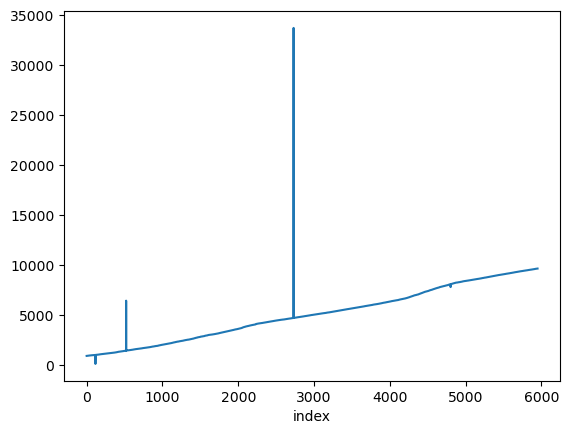

In [13]:
# function check data
def check_data_meter_idx(df):
    # sort and set index data
    df = df.sort_values('received_time', ascending=True)
    df['index'] = range(len(df))
    df = df.set_index('index')
    
    # tính meter_id được thêm vào sau mỗi ngày
    demand = []
    demand.append(0)
    for i in df.index:
        if i >=1 :
            arr = df['meter_idx'][i] - df['meter_idx'][i-1]          
            demand.append(arr)
            
    df['demand_by_id'] = demand
    return df

# function check meter_idx ascending
def list_meter_idx_issue(df):
    
    df = df.sort_values('received_time', ascending=True)
    df['index'] = range(len(df))
    df = df.set_index('index')
    # tính meter_id được thêm vào sau mỗi ngày

    for i in df.index:
        if i >=1 :
            arr = df['meter_idx'][i] - df['meter_idx'][i-1]
            #add to list id have issue
            
            if arr<0:
                return df['meter_id'][i]

    return '-1'


#display check data
def display_check_meter_idx_issue(df):
    list_id = []
    for item in df['meter_id'].unique():
        data_item = df[df['meter_id'] == item]
        check = list_meter_idx_issue(data_item)
        list_id.append(check)

    df_list_issue=pd.DataFrame(list_id, columns=['meter_id_issue'])

    id_issue = df_list_issue[df_list_issue['meter_id_issue'] != '-1']
    if len(id_issue) == 0:
        print('OK')
    else:
        data_item = df[df['meter_id'] == id_issue[:1]['meter_id_issue'].values[0]]
        data_item_check = check_data_meter_idx(data_item)
        print('meter_id = ', item)
        data_item_check['meter_idx'].plot(kind = 'line');

# display chart if have issue in meter_idx
display_check_meter_idx_issue(df_elog)

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Quality issues
</h5>
<ol>

  <li style = "color: Navy ; bottom: 30px;">inaccurate data</li>
     Lượng điện tiêu thụ được ghi lại không đúng theo meter_id theo thời gian
</ol>

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Solution
</h5>
<ol>
<li style = "color: Navy ; bottom: 30px;">meter_idx</li>
     -> thay đổi giá trị meter_idx của dòng có chỉ số meter_idx thấp hơn thời gian trước đo theo meter_id
<br>
    
</ol>

In [14]:
# function filter data
def filter_meter_idx(df):
    # sort and set index data
    df_filter = df.sort_values('received_time', ascending=True)
    df_filter['index'] = range(len(df_filter))
    df_filter = df_filter.set_index('index')
    
    # list of index with inaccurate meter_idx
    list_id = []
    # filter meter_idx thấp hơn ngày hơn trước
    for i in df_filter.index:      
        if df_filter['meter_idx'][0] > df_filter['meter_idx'][1]:
            df_filter['meter_idx'][1] = df_filter['meter_idx'][0]
            
        if i >=2 :
            # tìm vị trí tại đó giá trị meter_idx của i thấp hơn i-1
            arr = df_filter['meter_idx'][i] - df_filter['meter_idx'][i-1]
            if arr < 0:
                
                # Tính hiệu i-2 và i, nếu hiệu > 0 thì vị trí i có vấn đề, ngược lại thì i-1 có vấn đề 
                # Sau đó thay thế vị trí có vấn đề bằng giá trị trước no
                diffi = df_filter['meter_idx'][i-2] - df_filter['meter_idx'][i]
                if diffi < 0:
                    df_filter['meter_idx'][i-1] = df_filter['meter_idx'][i-2] 
                else:
                    df_filter['meter_idx'][i] = df_filter['meter_idx'][i-1] 
    
    return df_filter


# filter for inaccurate data
df_elog_filter = df_elog[:0]
for item in df_elog['meter_id'].unique():
    
    # create new table with series of date  
    data_item = df_elog[df_elog['meter_id'] == item]
    
    #filter meter_idx thấp hơn ngày hơn trước
    data_item_filter = filter_meter_idx(data_item)
    
    #add
    df_elog_filter = pd.concat([df_elog_filter,data_item_filter])


# check result
display_check_meter_idx_issue(df_elog_filter)

# df_elog_filter.to_csv('df_elog_filter.csv', index=False)

C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i] = df_filter['meter_idx'][i-1]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i-1] = df_filter['meter_idx'][i-2]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i-1] = df_filter['meter_idx'][i-2]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i-1] = df_filter['meter_idx'][i-2]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i-1] = df_filter['meter_idx'][i-2]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i] = df_filter['meter_idx'][i-1]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][1] = df_filter['meter_idx'][0]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i] = df_filter['meter_idx'][i-1]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i] = df_filter['meter_idx'][i-1]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i-1] = df_filter['meter_idx'][i-2]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i-1] = df_filter['meter_idx'][i-2]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['meter_idx'][i] = df_filter['meter_idx'][i-1]
C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3191283649.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

OK


In [15]:
df_elog = df_elog_filter.copy()

In [16]:
# check result
df_elog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604134 entries, 0 to 311
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   customer_id    604134 non-null  object        
 1   meter_id       604134 non-null  object        
 2   received_time  604134 non-null  datetime64[ns]
 3   meter_idx      604134 non-null  float64       
 4   source         604134 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 27.7+ MB


In [17]:
# df_elog.to_csv('df_elog.csv', index=False)

<p style = "color: MidnightBlue ; font-weight: bold;">
 3. Load the weather by time data (HCM02-EWeather.csv)
</p>

In [18]:
# check information
df_eweather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122393 entries, 32047 to 101048
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   date          122393 non-null  object
 1   city          122393 non-null  object
 2   temp          121386 non-null  object
 3   dew_point     121395 non-null  object
 4   humidity      121394 non-null  object
 5   cloud_cover   120412 non-null  object
 6   trend         121407 non-null  object
 7   summary       121411 non-null  object
 8   wind_speed    119545 non-null  object
 9   visibility    120954 non-null  object
 10  pressure      50446 non-null   object
 11  wind_bearing  113319 non-null  object
dtypes: object(12)
memory usage: 12.1+ MB


<h5 style = "color: MidnightBlue ;font-weight: bold;">
Quality issues
</h5>

<ol>
  <li style = "color: Navy ; bottom: 30px;">Data Types</li>
    Data Format for temp,dew_point,humidity,cloud_cover,wind_speed,visibility,pressure,wind_bearing columns in df_eweather table ("HCM02-EWeather.csv") must be timestamp format instead of string format
    
   <br/>  
  <li style = "color: Navy ; bottom: 30px;">Missing data</li>
     Missing value of  temp,dew_point,humidity,cloud_cover,wind_speed,visibility,pressure,wind_bearing columns in df_eweather table ("HCM02-EWeather.csv")
</ol>


<h5 style = "color: MidnightBlue ;font-weight: bold;">
Solution
</h5>
<ol>
    
<li style = "color: Navy ; bottom: 30px;">temp,dew_point,humidity,cloud_cover,wind_speed,visibility,pressure,wind_bearing</li>
    -> change to datatime type
    -> fill by interpolate
</ol>

In [19]:
# Change format of list columns ['temp','dew_point','humidity','cloud_cover','wind_speed','visibility','pressure','wind_bearing'] 
# to float and date to datetime
cols_to_price = ['temp','dew_point','humidity','cloud_cover','wind_speed','visibility','pressure','wind_bearing']
for col in cols_to_price:
    df_eweather[col] = df_eweather[col].astype(float)
    
df_eweather['date'] = pd.to_datetime(df_eweather['date'])

In [20]:
df_eweather = df_eweather.sort_values(['city', 'date'], ascending=[True,False])

<p>  Export data to test 3 methode fill null for time series: Forward fill, Back fill and Leaner interpolation 
</p>

In [21]:
# copy data not null
df_samble = pd.DataFrame(df_eweather['temp'][102629:102807])
df_samble.isna().sum()

temp    0
dtype: int64

In [22]:
# set index
df_samble['index'] = range(len(df_samble))
df_samble = df_samble.set_index('index')

In [23]:
# using Leaner interpolation to fill 
df_samble['index'] = range(len(df_samble))
df_samble = df_samble.set_index('index')

df_samble['index'] = range(len(df_samble))
df_samble = df_samble.set_index('index')
df_samble['TempMissing'] = df_samble['temp']
df_samble['TempMissing'][(df_samble.index%2 == 0) & (df_samble.index != 0)] = np.NaN
df_samble['Temp_Bfill'] = df_samble['Temp_Ffill'] = df_samble['Temp_Interpolate'] =  df_samble['TempMissing']

df_samble['Temp_Bfill'].fillna(method='bfill', inplace=True)
df_samble['Temp_Ffill'].fillna(method='ffill', inplace=True)
df_samble['Temp_Interpolate'] = df_samble['Temp_Interpolate'].interpolate(method='linear')

print('Forward fill = ',np.mean(np.abs(df_samble['temp']-df_samble['Temp_Ffill'])))
print('Back fill = ',np.mean(np.abs(df_samble['temp']-df_samble['Temp_Bfill'])))
print('Leaner interpolation = ',np.mean(np.abs(df_samble['temp']-df_samble['Temp_Interpolate'])))

Forward fill =  0.3258426966292135
Back fill =  0.3088202247191012
Leaner interpolation =  0.18345505617977537


In [24]:
# We can use Leaner interpolation to filling null of temp,dew_point,humidity,cloud_cover,wind_speed,visibility,pressure,wind_bearing columns 
cols_to_price = ['temp','dew_point','humidity','cloud_cover','wind_speed','visibility','pressure','wind_bearing']
for col in cols_to_price:
    df_eweather[col] = df_eweather[col].interpolate(method='linear')

In [25]:
#check result after fill null
df_eweather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122393 entries, 107203 to 24768
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          122393 non-null  datetime64[ns]
 1   city          122393 non-null  object        
 2   temp          122393 non-null  float64       
 3   dew_point     122393 non-null  float64       
 4   humidity      122393 non-null  float64       
 5   cloud_cover   122393 non-null  float64       
 6   trend         121407 non-null  object        
 7   summary       121411 non-null  object        
 8   wind_speed    122392 non-null  float64       
 9   visibility    122393 non-null  float64       
 10  pressure      122393 non-null  float64       
 11  wind_bearing  122393 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(3)
memory usage: 12.1+ MB


In [26]:
# df_eweather.to_csv('df_eweather.csv', index=False)

#### Merge 3 dataset

In [27]:
# Enrich city and sector to elog data and change name to df_elog_eprofit
df_elog_eprofit = pd.merge(df_elog, df_eprofit , how='left', on='customer_id')

#check data elog not change row after joining left
print('f_elog.shape = ', df_elog.shape)
print('df_elog_eprofit.shape = ', df_elog_eprofit.shape)

#df_elog = pd.merge(df_elog, df_eweather, how='left', on='city')

f_elog.shape =  (604134, 5)
df_elog_eprofit.shape =  (604134, 8)


In [28]:
#Sort data
df_elog_eprofit = df_elog_eprofit.sort_values(['city', 'received_time'], ascending=[True,False])

# Keyjoin = %Y%m%d%H + city
df_elog_eprofit['Keyjoin'] = df_elog_eprofit['received_time'].dt.strftime('%Y%m%d%H')
df_elog_eprofit['Keyjoin'] = df_elog_eprofit["Keyjoin"].str.cat(df_elog_eprofit["city"])

In [29]:
# Create Keyjoin = %Y%m%d%H + city
df_eweather_join = df_eweather[df_eweather['city'] != '-1']
df_eweather_join['Keyjoin'] = df_eweather_join['date'].dt.strftime('%Y%m%d%H').str.cat(df_eweather_join["city"], sep='')
# df_eweather['Keyjoin'] = df_eweather["Keyjoin"].str.cat(df_elog_eprofit["city"])
df_eweather_join = df_eweather_join.drop(columns = ['city'])


C:\Users\P.Q.TRI\AppData\Local\Temp\ipykernel_11132\3225317772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eweather_join['Keyjoin'] = df_eweather_join['date'].dt.strftime('%Y%m%d%H').str.cat(df_eweather_join["city"], sep='')


In [30]:
# Check duplicate key join of right table
df_eweather_join[df_eweather_join.duplicated(subset=['Keyjoin'], keep = False)].sort_values('Keyjoin')

Empty DataFrame
Columns: [date, temp, dew_point, humidity, cloud_cover, trend, summary, wind_speed, visibility, pressure, wind_bearing, Keyjoin]
Index: []

In [31]:
df_elog_eprofit_eweather = pd.merge(df_elog_eprofit, df_eweather_join , how='left', on='Keyjoin')

#check data elog not change row after joining left
print('df_elog_eprofit.shape = ', df_elog_eprofit.shape)
print('df_elog_eprofit_eweather.shape = ', df_elog_eprofit_eweather.shape)

df_elog_eprofit.shape =  (604134, 9)
df_elog_eprofit_eweather.shape =  (604134, 20)


<AxesSubplot:>

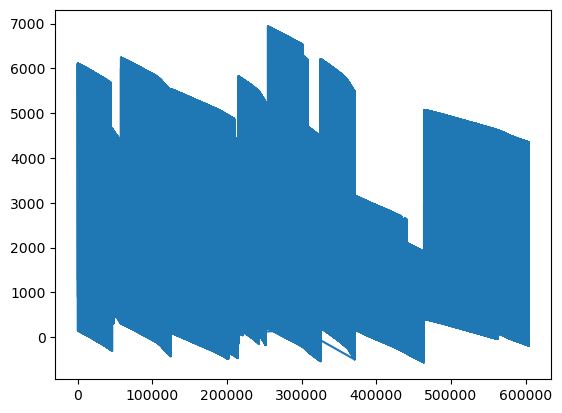

In [32]:
# sort data
df_elog_eprofit_eweather = df_elog_eprofit_eweather.sort_values(['city', 'received_time'], ascending=[True,True])
df_elog_eprofit_eweather_fill = df_elog_eprofit_eweather.copy()
# Check received_time and registration_date
df_elog_eprofit_eweather_fill['Diff'] = df_elog_eprofit_eweather_fill['received_time'] - df_elog_eprofit_eweather_fill['registration_date']
df_elog_eprofit_eweather_fill['Diff'] = df_elog_eprofit_eweather_fill['Diff'].dt.days
# Check dữ liệu
df_elog_eprofit_eweather_fill['Diff'].plot(kind='line')

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Quality issues
</h5>
<ol>

  <li style = "color: Navy ; bottom: 30px;">inaccurate data</li>
     received_time is before of registration_date
</ol>

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Solution
</h5>
<ol>
<li style = "color: Navy ; bottom: 30px;">Diff date is negative</li>
     -> filter Diff < 0
<br>
    
</ol>

In [33]:
# filter dữ liệu với ngày ghi trước ngày đăng kí
df_elog_eprofit_eweather_fill = df_elog_eprofit_eweather_fill[df_elog_eprofit_eweather_fill['Diff'] >= 0]
df_elog_eprofit_eweather_fill = df_elog_eprofit_eweather_fill.drop(columns = ['Diff'])
df_elog_eprofit_eweather_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 476526 entries, 57825 to 463866
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer_id        476526 non-null  object        
 1   meter_id           476526 non-null  object        
 2   received_time      476526 non-null  datetime64[ns]
 3   meter_idx          476526 non-null  float64       
 4   source             476526 non-null  object        
 5   registration_date  476526 non-null  datetime64[ns]
 6   city               429499 non-null  object        
 7   sector             454203 non-null  object        
 8   Keyjoin            429499 non-null  object        
 9   date               424092 non-null  datetime64[ns]
 10  temp               424092 non-null  float64       
 11  dew_point          424092 non-null  float64       
 12  humidity           424092 non-null  float64       
 13  cloud_cover        424092 non-null  floa

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Quality issues
</h5>
<ol>

  <li style = "color: Navy ; bottom: 30px;">Missing data</li>
     Missing value of  city,sector, trend, summary, temp,dew_point,humidity,cloud_cover,wind_speed,visibility,pressure,wind_bearing columns in df_elog_eprofit_eweather table
</ol>

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Solution
</h5>
<ol>
<li style = "color: Navy ; bottom: 30px;">city,sector</li>
     -> fill null by -1
<br>
    
<li style = "color: Navy ; bottom: 30px;">trend, summary</li>
     -> fill null by -1
    -> fill  by ffill
<br>
    
<li style = "color: Navy ; bottom: 30px;">temp,dew_point,humidity,cloud_cover,wind_speed,visibility,pressure,wind_bearing</li>
     -> fill null by -1
    -> fill  by interpolate
</ol>

In [34]:

# sort data
df_elog_eprofit_eweather_fill = df_elog_eprofit_eweather_fill.sort_values(['city', 'received_time'], ascending=[True,True])

# fill null data
df_elog_eprofit_eweather_fill = df_elog_eprofit_eweather_fill.drop(columns = ['date', 'Keyjoin'])
cols_to_price = ['temp','dew_point','humidity','cloud_cover','wind_speed','visibility','pressure','wind_bearing']
for col in cols_to_price:
    df_elog_eprofit_eweather_fill[col] = df_elog_eprofit_eweather_fill[col].interpolate(method='linear')
    
df_elog_eprofit_eweather_fill = df_elog_eprofit_eweather_fill.fillna({'city':'-1', 'sector':'-1'})
df_elog_eprofit_eweather_fill['summary'].fillna(method='ffill', inplace=True)
df_elog_eprofit_eweather_fill['trend'].fillna(method='ffill', inplace=True)

df_elog_eprofit_eweather_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 476526 entries, 57825 to 463866
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer_id        476526 non-null  object        
 1   meter_id           476526 non-null  object        
 2   received_time      476526 non-null  datetime64[ns]
 3   meter_idx          476526 non-null  float64       
 4   source             476526 non-null  object        
 5   registration_date  476526 non-null  datetime64[ns]
 6   city               476526 non-null  object        
 7   sector             476526 non-null  object        
 8   temp               476526 non-null  float64       
 9   dew_point          476526 non-null  float64       
 10  humidity           476526 non-null  float64       
 11  cloud_cover        476526 non-null  float64       
 12  trend              476526 non-null  object        
 13  summary            476526 non-null  obje

In [38]:
# group dữ liệu theo ngày theo meter_id
df_nergy_consumption_unique_date = df_nergy_consumption.copy()

# add received_date
df_nergy_consumption_unique_date['received_date'] = df_nergy_consumption_unique_date['received_time'].dt.normalize()

df_nergy_consumption_unique_date = df_nergy_consumption_unique_date.groupby(['meter_id','received_date'], as_index=False).agg({
    'customer_id':'first',\
    'received_time':'min', \
    'meter_idx':'first', \
    'source':'first', \
    'registration_date':'min',\
    'city':'first',\
    'sector':'first',\
    'temp':'mean',\
    'dew_point':'mean',\
    'humidity':'mean',\
    'cloud_cover':'mean',\
    'trend':'first',\
    'summary':'first',\
    'wind_speed':'mean',\
    'visibility':'mean',\
    'pressure':'mean',\
    'wind_bearing':'mean',\
})

In [39]:
def groupby_date_nergy(col, df):
#     df_nergy_consumption_sum_date = df_nergy_consumption_unique_date.copy()
    df = df.sort_values('received_time', ascending=True)
    df = df.groupby('received_date', as_index=False).agg({
        'customer_id':'count', \
        'meter_idx':'sum', \
        'source':'first', \
        'temp':'mean',\
        'dew_point':'mean',\
        'humidity':'mean',\
        'cloud_cover':'mean',\
        'trend':'first',\
        'summary':'first',\
        'wind_speed':'mean',\
        'visibility':'mean',\
        'pressure':'mean',\
        'wind_bearing':'mean',\
    })
    
    df = df.sort_values('received_date', ascending=True)
    # tính meter_id được thêm vào sau mỗi ngày
    demand = []
    demand.append(0)
    for i in df.index:
        if i >=1 :
            arr = df[col][i] - df[col][i-1]
            demand.append(arr)

    df['meter_add'] = demand
    return df

def check_demand_consumption_day(col, df, tle):
    df = df.sort_values('received_date', ascending=True)

    # tính meter_id được thêm vào sau mỗi ngày
    demand = []
    demand.append(0)
    for i in df.index:
        if i >=1 :
            arr = df[col][i] - df[col][i-1]
            demand.append(arr)

    df['meter_add'] = demand

    # df_nergy_consumption_sum_date['meter_add'].plot(kind = 'line');
    fig = px.line(df, x='received_date', y='meter_add', title=tle)
    fig.show()
    

In [40]:
# check by meter_idx
fig = px.line(groupby_date_nergy('meter_idx',df_nergy_consumption_unique_date), x='received_date', y='meter_add', title='meter_idx tăng theo thời gian')
fig.show()

In [41]:
# check by meter_idx
fig = px.line(groupby_date_nergy('customer_id',df_nergy_consumption_unique_date), x='received_date', y='meter_add', title='số lượng customer_id tăng theo thời gian')
fig.show()

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Quality issues
</h5>

<ol>
  <li style = "color: Navy ; bottom: 30px;">Missing data</li>
    + Số lượng meter_id thêm vào bị âm nên số điện không được ghi lại đều đặng hằng ngày
  <br/>  
</ol>

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Solution
</h5>
<ol>
    
<li style = "color: Navy ; bottom: 30px;">meter_id</li>
    -> fill null
</ol>

In [42]:
# Fill null data for missing date
def fillnull_date_nergy(df):
    maxday = df['received_date'].max()
    df_fill = df[:0]
    for item in df['meter_id'].unique():
        # create new table with series of date  
        data_item = df[df['meter_id'] == item]
        minday = data_item['received_date'].min()
        idx = pd.date_range(minday, periods=(maxday - minday).days + 1, freq="D")
        ts=pd.DataFrame(idx, columns=['received_date'])

        #merge date
        ts_merge  = pd.merge(ts, data_item, how='left', on='received_date')

        # fill null value
        v_customer_id = ts_merge['customer_id'].mode()[0]
        v_meter_id = ts_merge['meter_id'].mode()[0]
        v_city = ts_merge['city'].mode()[0]
        v_registration_date = ts_merge['registration_date'].mode()[0]
        v_sector = ts_merge['sector'].mode()[0]
#       v_source = ts_merge['source'].mode()
        ts_merge = ts_merge.fillna({'customer_id':v_customer_id, 'meter_id':v_meter_id})
        ts_merge['received_time'] = np.where(ts_merge["received_time"].isnull() == True, ts_merge["received_date"], ts_merge["received_time"] )

        
        # fill null by interpolate
        cols_to_price = ['meter_idx','temp','dew_point','humidity','cloud_cover','wind_speed','visibility','pressure','wind_bearing']
        for col in cols_to_price:
            ts_merge[col] = ts_merge[col].interpolate(method='linear')
            
        # fill null ffill for summary, trend
        ts_merge['summary'].fillna(method='ffill', inplace=True)
        ts_merge['trend'].fillna(method='ffill', inplace=True)
        
        #add
        df_fill = pd.concat([df_fill,ts_merge])

    return df_fill

In [43]:
# fill data theo date
df_fill = fillnull_date_nergy(df_nergy_consumption_unique_date)

In [44]:
# check by meter_idx
fig = px.line(groupby_date_nergy('meter_idx',df_fill), x='received_date', y='meter_add', title='meter_idx tăng theo thời gian(sau khi fill)')
fig.show()

In [45]:
# check by meter_idx
fig = px.line(groupby_date_nergy('customer_id',df_fill), x='received_date', y='meter_add', title='số lượng customer_id tăng theo thời gian(sau khi fill)')
fig.show()

In [46]:
df_fill['source'].isna().sum()

13960

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Quality issues
</h5>
<ol>
<!--   <li style = "color: Navy ; bottom: 30px;">Missing data</li> -->
    Source bị thiếu data
</ol>

<h5 style = "color: MidnightBlue ;font-weight: bold;">
Solution
</h5>
<ol>
    
<li style = "color: Navy ; bottom: 30px;">Source</li>
    -> fill null bằng chách đổi giá trị train, test = 1, 2. Sau đó fill null bằng ffill
</ol>

In [47]:
df_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95444 entries, 0 to 123
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   meter_id           95444 non-null  object        
 1   received_date      95444 non-null  datetime64[ns]
 2   customer_id        95444 non-null  object        
 3   received_time      95444 non-null  datetime64[ns]
 4   meter_idx          95444 non-null  float64       
 5   source             81484 non-null  object        
 6   registration_date  81484 non-null  datetime64[ns]
 7   city               81484 non-null  object        
 8   sector             81484 non-null  object        
 9   temp               95444 non-null  float64       
 10  dew_point          95444 non-null  float64       
 11  humidity           95444 non-null  float64       
 12  cloud_cover        95444 non-null  float64       
 13  trend              95444 non-null  object        
 14  summary 

In [48]:
df_fill['source'] = np.where(df_fill["source"] == 'train', 1 , 2 )
df_fill = df_fill.sort_values(['meter_id', 'received_date'], ascending=[True, True])
df_fill['source'].fillna(method='ffill', inplace=True)
df_fill['source'].isna().sum()
# df_fill = df_fill.drop(columns = ['source'])

0

In [ ]:
# df_fill.to_csv('df_fill.csv', index=False)

<a id="4"></a>
<h1 style = "color:Maroon ">IV. Data exploration</h1>

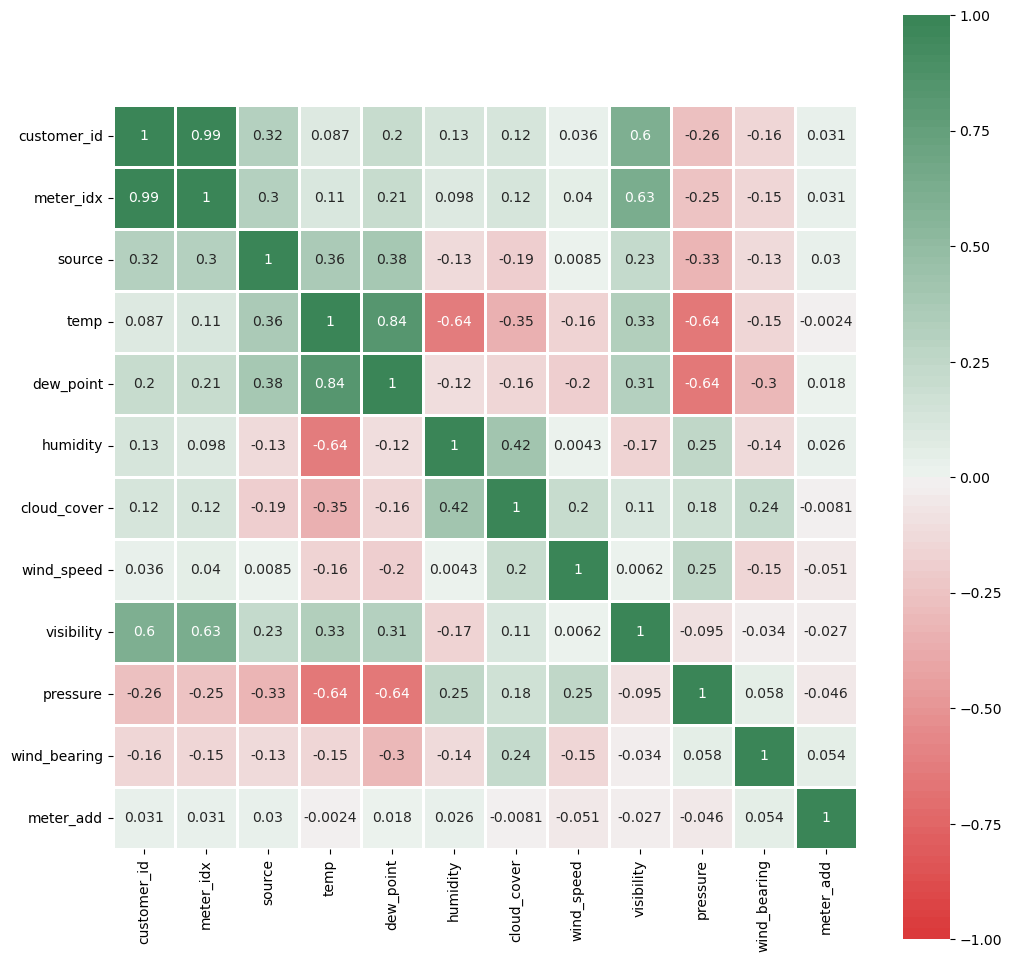

In [54]:
# Create heatmap hart
data_group = groupby_date_nergy('meter_idx',df_fill)
fig, axes = plt.subplots(figsize=(12, 12))
corr = data_group.corr()
axes = sns.heatmap(corr, annot=True, center=0, linewidths=1, square=True, cmap=sns.diverging_palette(12, 500, n = 100), vmin=-1, vmax=1)

Kết luận:

+ temp có liên quan với dew_point, humidity và pressure
+ merter_idx có lien quan đến visibility và customer_id

In [63]:
# check by meter_idx
fig = px.line(df_fill, x='received_date', y='meter_idx', title='meter_idx theo thời gian')
fig.show()

In [61]:
# df_fill.to_csv('df_fill.csv', index=False)

<a id="5"></a>
<h1 style = "color:Maroon ">V. Feature engineering</h1>

array([<AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>], dtype=object)

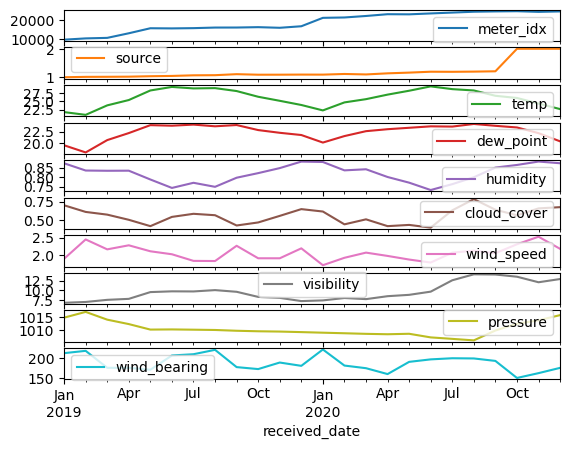

In [70]:
df_fill_time = df_fill.copy()
df_fill_time=df_fill_time.set_index('received_date')
df_fill_time.resample('M').mean().plot(subplots=True)

array([<AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>,
       <AxesSubplot:xlabel='received_date'>], dtype=object)

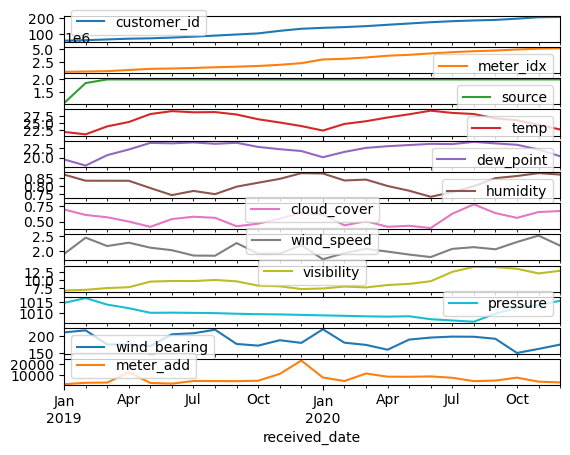

In [71]:

data_group_time = data_group.copy()
data_group_time=data_group_time.set_index('received_date')
data_group_time.resample('M').mean().plot(subplots=True)

<a id="6"></a>
<h1 style = "color:Maroon ">VI. Predictive modeling</h1>

In [72]:
final_df=data_group_time.resample('M').mean()

In [74]:
final_df.to_csv('final_df.csv', index=False)

In [ ]:
train = 

<a id="7"></a>
<h1 style = "color:Maroon ">VII. Data visualation</h1>